# 🛒 Store Sales Time Series Forecasting

This notebook applies classical and machine learning-based time series techniques to the [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting) dataset from Kaggle.

Our objective is to forecast daily product sales for specific stores and product families using a combination of methods, including:

- Exploratory Data Analysis (EDA)
- Time Series Decomposition
- Machine Learning Models for Time Series
- Evaluation with MAE and RMSE metrics

We enhance the forecasts by incorporating external variables such as holidays and oil prices as additional regressors.

https://www.kaggle.com/code/doggypiggy/store-sales-getting-started-with-time-series#Defining-the-Training-Date

## Loading Libraries and Data Sets

In [1]:
# Core Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
# Modelling
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, root_mean_squared_log_error


# Date handling
import kagglehub
from kagglehub import competition_download
from datetime import datetime


In [3]:
download_path = competition_download('store-sales-time-series-forecasting')

# Load the datasets into pandas DataFrames
train = pd.read_csv(download_path + '/train.csv')
test = pd.read_csv(download_path + '/test.csv')
oil = pd.read_csv(download_path + '/oil.csv')
holidays = pd.read_csv(download_path + '/holidays_events.csv')

## Explanatory Data Analysis
### Train



In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


#### Convert date columns to datetime format

In [5]:
# Convert date columns to datetime format for proper handling
for df in [train, test, oil, holidays]:
    df['date'] = pd.to_datetime(df['date'])


In [6]:
# Check the first few rows of the train dataset
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


#### Missing Values?

In [7]:
# Check for missing values
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0


The train set does not have any missing values.

#### Sum of sales

Text(0, 0.5, 'Sales')

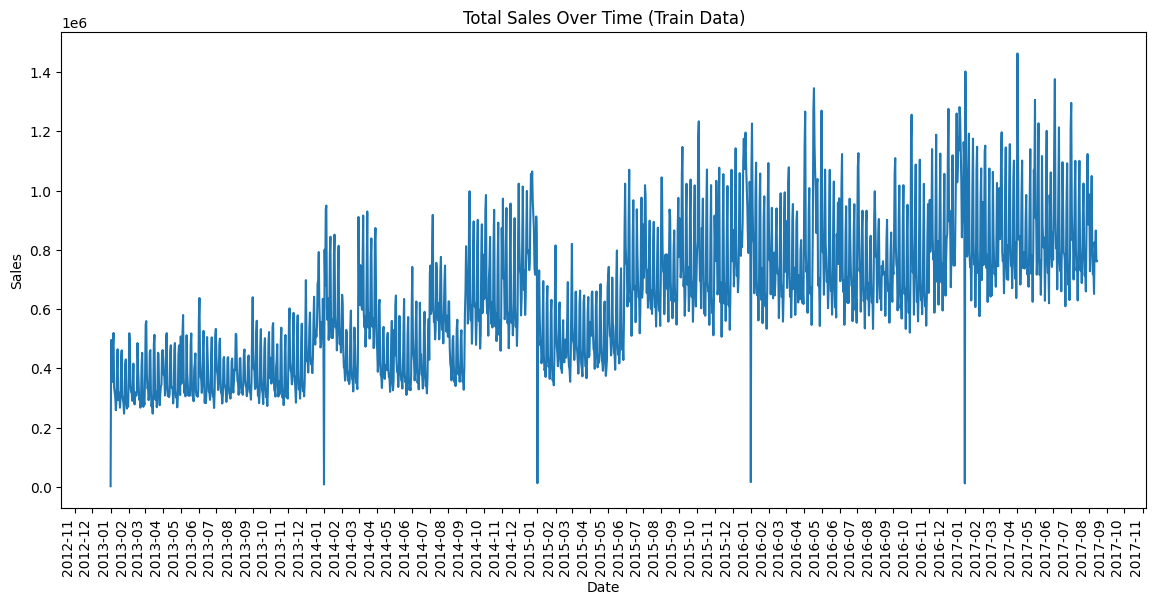

In [8]:
plt.figure(figsize=(14, 7))
train_grouped = train.groupby('date')['sales'].sum()
train_grouped.plot()

# Improve date formatting on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Every month
plt.xticks(rotation=90)

plt.title('Total Sales Over Time (Train Data)')
plt.xlabel('Date')
plt.ylabel('Sales')

##### Interpretation

The plot shows the total daily sales across all stores and product families from 2013 to 2017.

Noticable:
- A clear **upward trend** over the years, indicating increasing sales over time.
- **Seasonal patterns**: Sales spikes and dips appear regularly, suggesting possible weekly or yearly seasonality (e.g., holidays, promotions).
- **Sharp drops** at specific points (near-zero sales) likely correspond to holidays or events when stores were closed (e.g., Christmas, New Year's).
- **Increased variability**: As time progresses, the fluctuations in daily sales become larger, indicating growing volatility.

Overall, this suggests that modeling both trend and seasonality components will be important for accurate forecasting.

Next, we plot the total sales per store, alongside the mean.


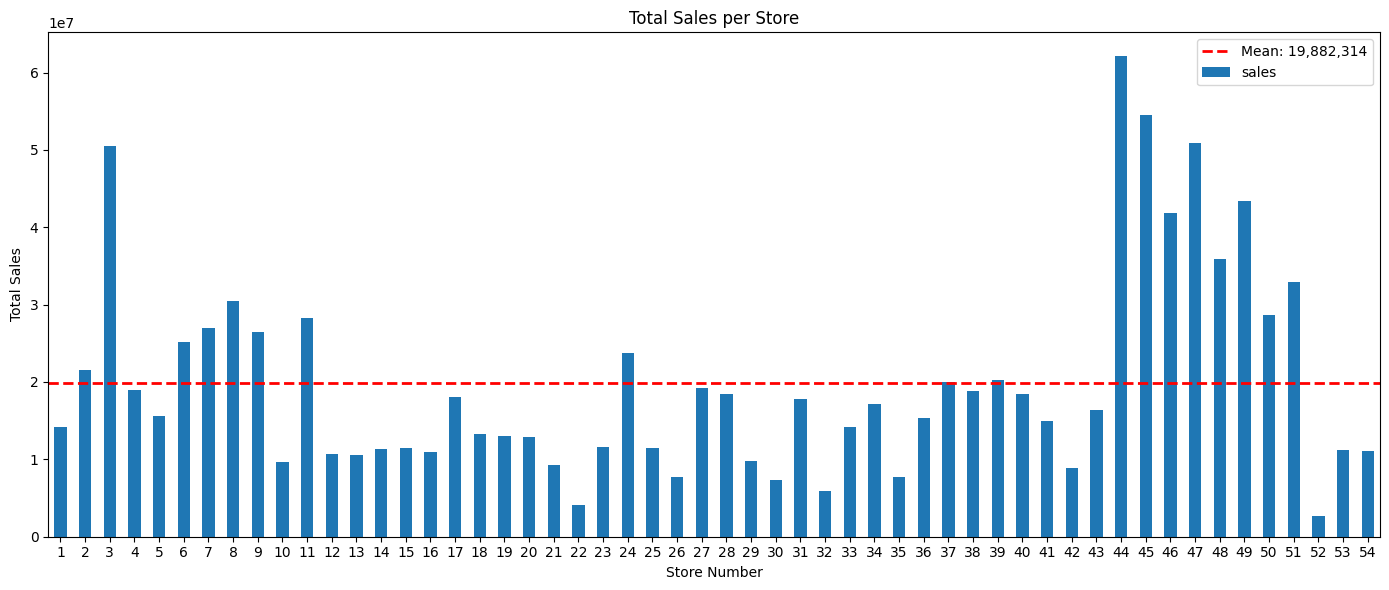

In [9]:
store_sales = train.groupby('store_nbr')['sales'].sum()

plt.figure(figsize=(14, 6))
store_sales.plot(kind='bar')

# Add horizontal line for the mean
mean_sales = store_sales.mean()
plt.axhline(mean_sales, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sales:,.0f}')

plt.title('Total Sales per Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.legend(loc='upper right')  # Move the legend inside
plt.tight_layout()
plt.show()

##### Interpretation

The plot shows the total sales across all 54 stores.

We observe:
- There are clear differences between the stores. Especially Store 3 and stores 44-51 are well above the mean.

This suggests differences in location, store size, or customer base.

The next plot shows the average sales by week day

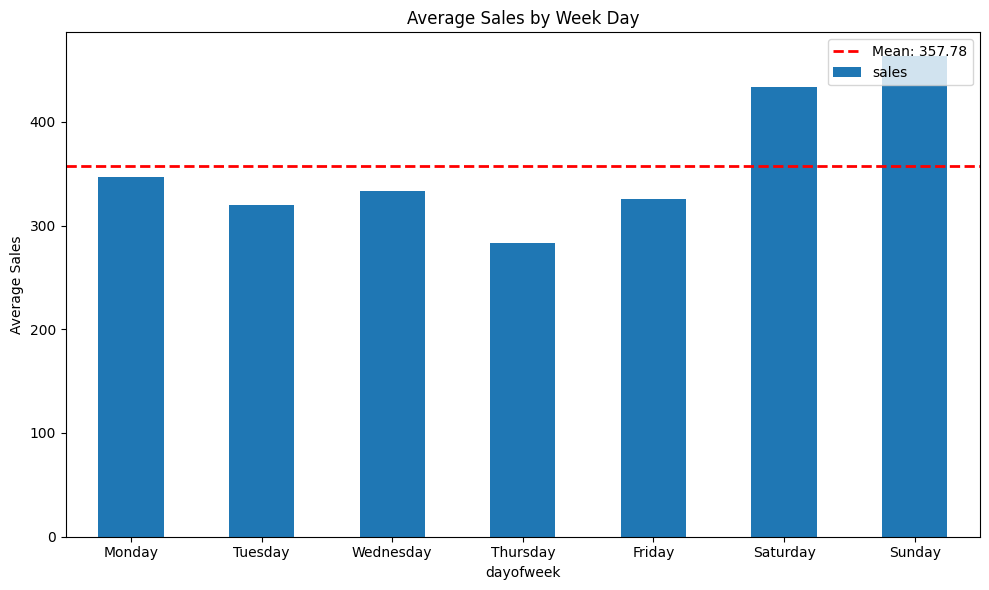

In [10]:
# Define mapping from numbers to day names
day_name_map = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}

train['dayofweek'] = train['date'].dt.dayofweek.astype(int)  # 0=Monday
# Group by existing numeric dayofweek column
avg_sales_dow = train.groupby('dayofweek')['sales'].mean().reindex(range(7))
mean_avg_sales_dow = avg_sales_dow.mean()
# Plot
plt.figure(figsize=(10, 6))
avg_sales_dow.plot(kind='bar')
plt.axhline(mean_avg_sales_dow, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_avg_sales_dow:,.2f}')
plt.title('Average Sales by Week Day')
plt.ylabel('Average Sales')
plt.xticks(ticks=range(7), labels=[day_name_map[i] for i in range(7)], rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

##### Interpretation

- **Weekday sales** (Monday to Friday) tend to be lower compared to weekends.
- **Thursday** has the **lowest average sales** among all days.
- **Saturday and Sunday** show **significantly higher average sales**, exceeding the overall mean (~358 sales).
- This pattern suggests that **customer activity is strongest during weekends**, possibly due to increased leisure shopping.

The following plot shows the sales distr. by products.

<ipython-input-11-9d9a55c9b2b1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x='sales', y='family', orient='h', palette='viridis')


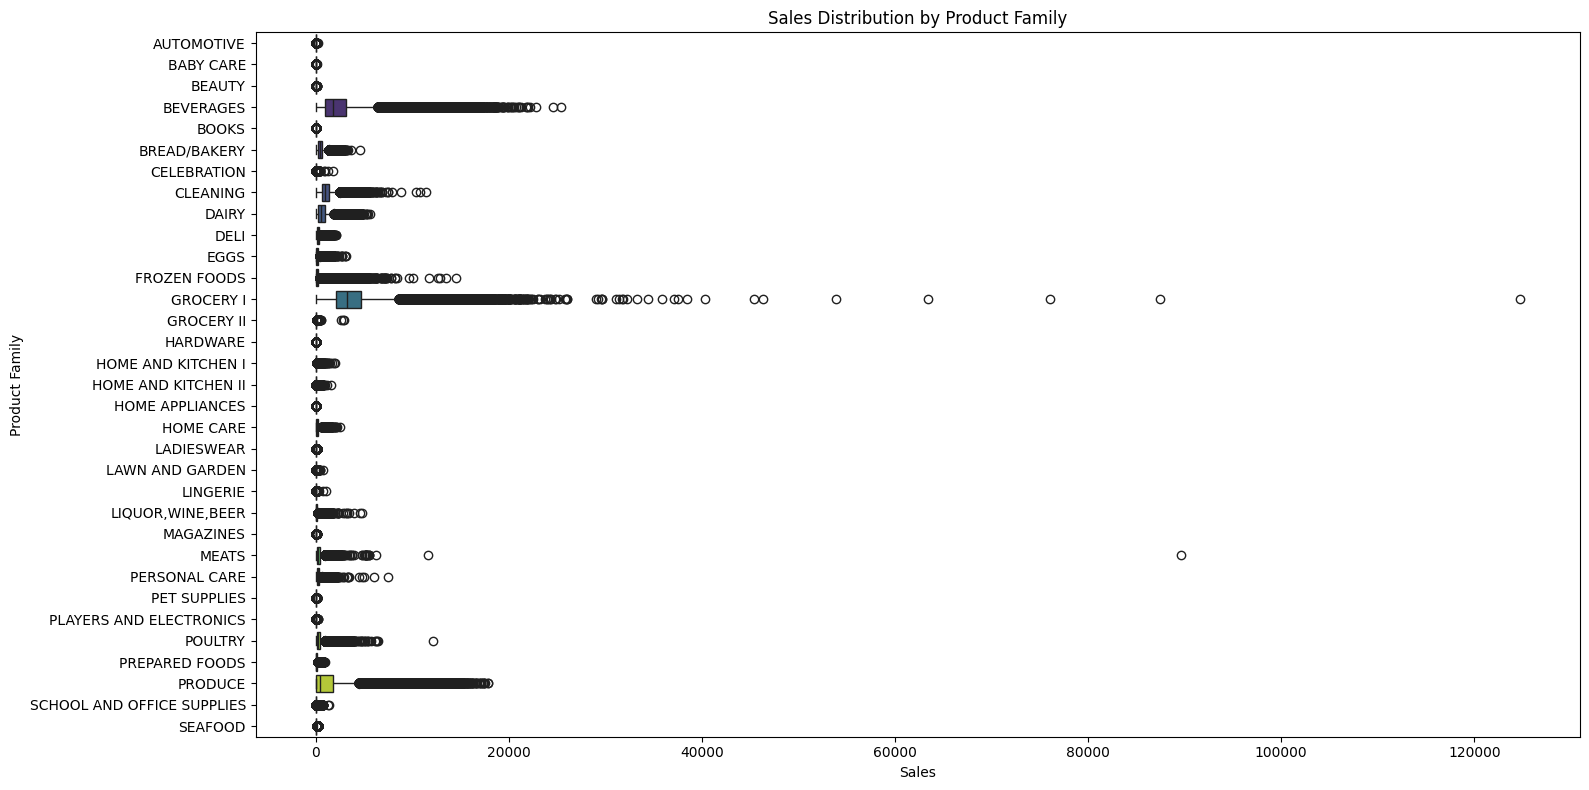

In [11]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=train, x='sales', y='family', orient='h', palette='viridis')
plt.title('Sales Distribution by Product Family')
plt.xlabel('Sales')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

##### Interpretation

- **Most product families** have low to moderate sales, clustered near the lower range.
- **Grocery I, Beverages, and Produce** stand out with **higher median sales** compared to other categories.
- Several product families, especially **Grocery I**, show **extreme outliers** with sales far exceeding typical values (up to ~120,000 units).
- **Categories like Seafood, Lawn and Garden, and Magazines** have relatively **low and less spread-out sales**.
- The presence of many outliers suggests that **special promotions or seasonal demand spikes** might impact specific product families significantly.

### Oil

This data set includes dates alongside the daily price of crude oil (WTI) measured at Cushing, Oklahoma.

In [12]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [13]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


Text(0, 0.5, 'Sales')

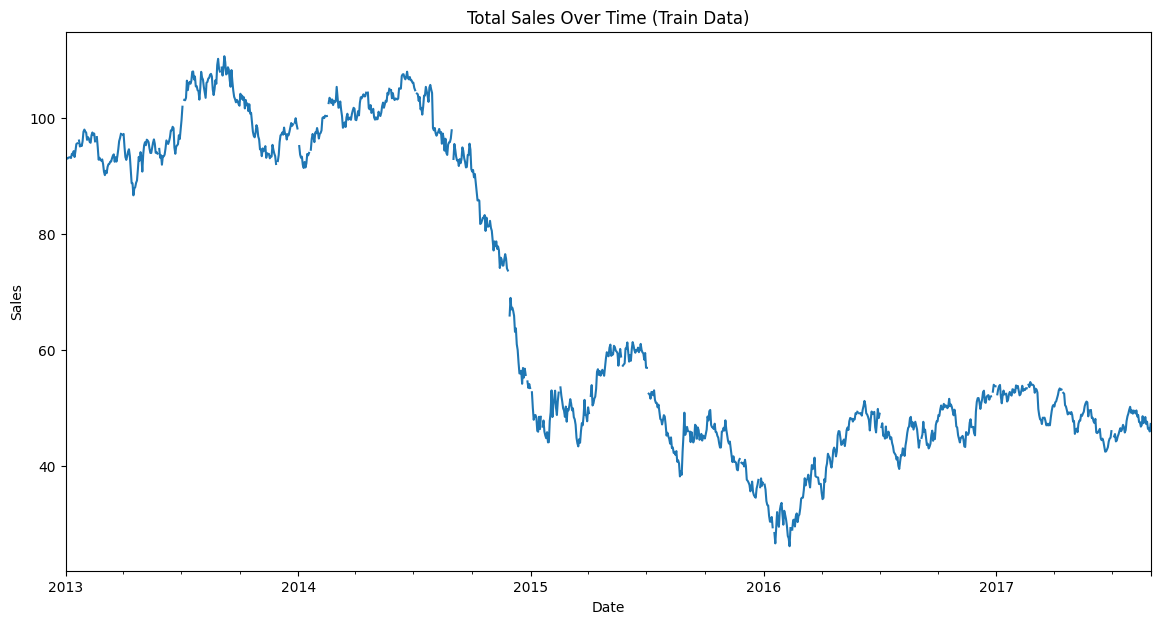

In [14]:
plt.figure(figsize=(14, 7))
oil_grouped = oil.groupby('date')['dcoilwtico'].mean()
oil_grouped.plot()

plt.title('Total Sales Over Time (Train Data)')
plt.xlabel('Date')
plt.ylabel('Sales')


##### Interpretation

The oil price is relatively stable up to 2014-06. Afterwards the price drops by about 50%.

### Holidays

In [15]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [16]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


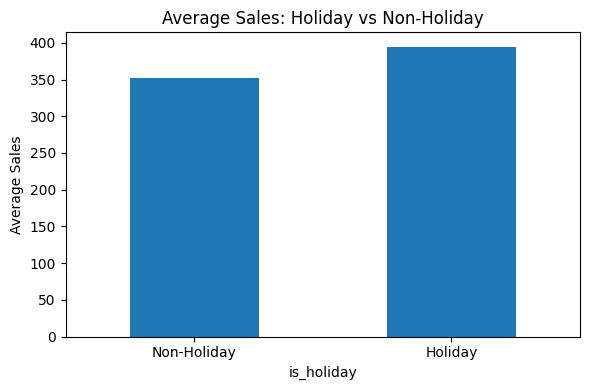

In [17]:
# Simplify the holidays dataframe
holidays_simple = holidays[['date', 'type']].drop_duplicates()
holidays_simple['date'] = pd.to_datetime(holidays_simple['date'])

# Merge into train
train_with_holidays = pd.merge(train, holidays_simple, on='date', how='left')
train_with_holidays['is_holiday'] = train_with_holidays['type'].notna()

# Compare average sales
avg_sales_holiday = train_with_holidays.groupby('is_holiday')['sales'].mean()

plt.figure(figsize=(6, 4))
avg_sales_holiday.plot(kind='bar')
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'], rotation=0)
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

Holidays have, on average, higher average sales.


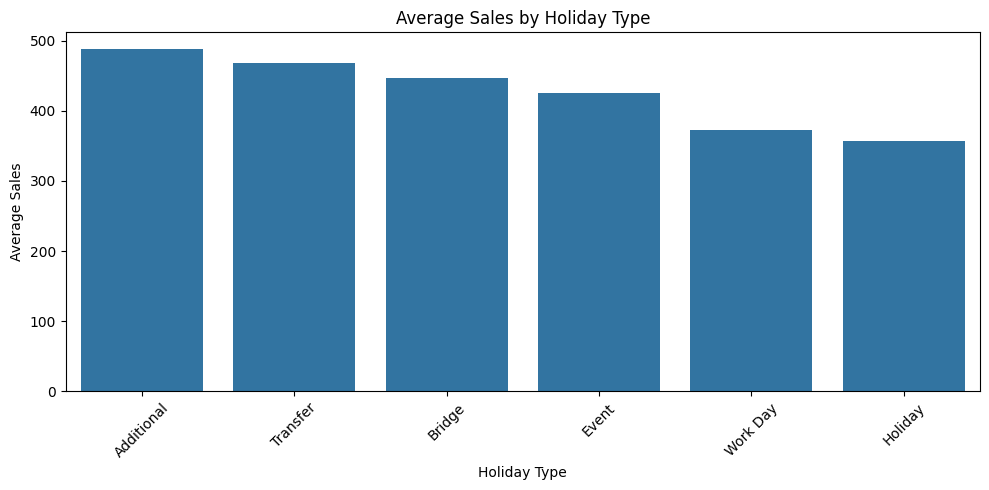

In [18]:
# Filter only rows with a holiday
holiday_sales = train_with_holidays[train_with_holidays['is_holiday']]

# Group by holiday type and calculate mean sales
avg_sales_by_type = holiday_sales.groupby('type')['sales'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_sales_by_type.index, y=avg_sales_by_type.values)
plt.title('Average Sales by Holiday Type')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
holidays['type'].value_counts()

,count
type,
Holiday,221
Event,56
Additional,51
Transfer,12
Bridge,5
Work Day,5



Because there are only 350 holidays in the entire data set, I choose to just capture whether a day is a holiday or not.

In [20]:
holiday_dates = set(holidays['date'])

# Create the is_holiday column
train['is_holiday'] = train['date'].isin(holiday_dates).astype(int)
test['is_holiday'] = test['date'].isin(holiday_dates).astype(int)

## Feature Engineering

In [21]:
test['dayofweek'] = test['date'].dt.dayofweek.astype(int)

for df in [train, test]:
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['is_weekend'] = df['dayofweek'] >= 5
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter

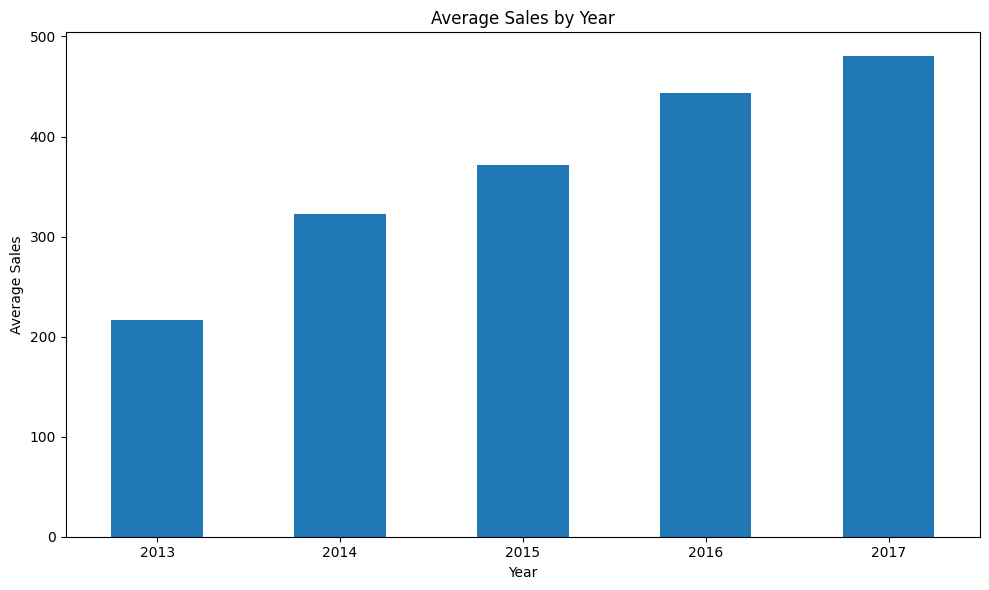

In [22]:
yearly_avg_sales = train.groupby('year')['sales'].mean()

plt.figure(figsize=(10, 6))
yearly_avg_sales.plot(kind='bar')
plt.title('Average Sales by Year')
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Avg. sales are rising every year.

#### Merge oil

In [23]:
# merge into train and val
train = pd.merge(train, oil, on='date', how='left')
test = pd.merge(test, oil, on='date', how='left')

for df in [train, test]:
    df['dcoilwtico'] = df['dcoilwtico'].ffill()

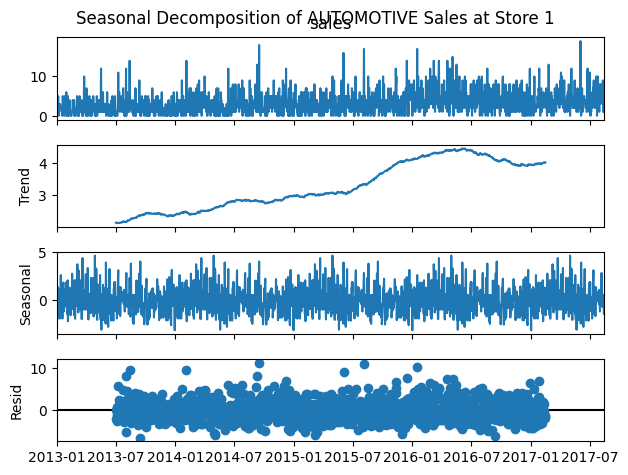

In [24]:
# Decompose the 'sales' time series for a specific store and family to analyze
store_id = 1  # example, you can change this to any store in the dataset
family_name = 'AUTOMOTIVE'  # example, change this to any family in the dataset

# Filter the data for the store and family
df_store_family = train[(train['store_nbr'] == store_id) & (train['family'] == family_name)]

# Set the date as the index
df_store_family = df_store_family.set_index('date')

# Perform seasonal decomposition
decomposition = seasonal_decompose(df_store_family['sales'], model='additive', period=365)

# Plot the decomposition components
decomposition.plot()
plt.suptitle(f'Seasonal Decomposition of {family_name} Sales at Store {store_id}')
plt.show()

Interpretation:

- Observed: Sales are volatile with frequent spikes
- Trend: Steady growth from 2013 to early 2016, then a slight decline or plateau
- Seasonality: Mild yearly patterns
- Residuals: Significant random noise remains, indicating unpredictable daily variations

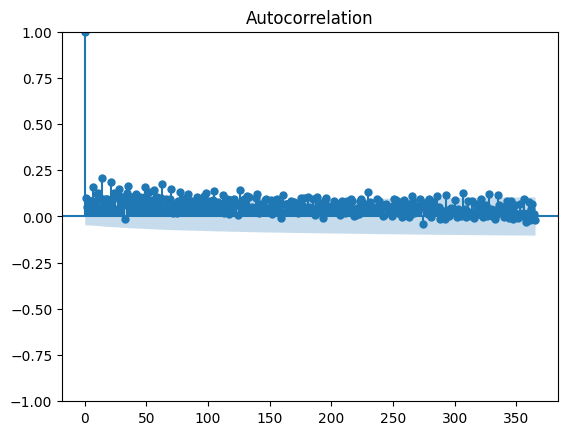

In [25]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_store_family['sales'], lags=365)
plt.show()

- Strong autocorrelation at lag 1, then quickly drops
- Subsequent lags show small, noisy correlations close to zero
- No clear strong seasonality detected over long lags

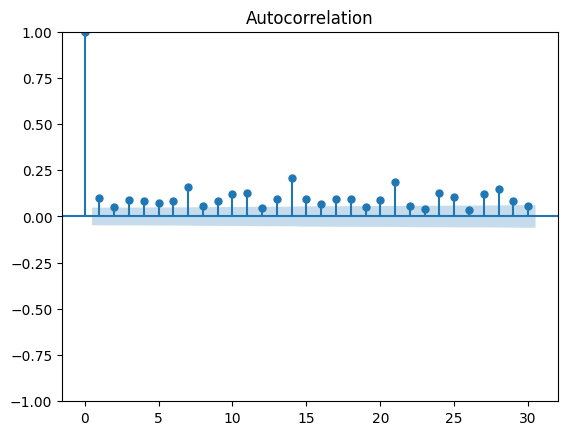

In [26]:
plot_acf(df_store_family['sales'], lags=30)  # Focus on shorter cycles
plt.show()

Autocorellation for first 30 days:

- Significant positive autocorrelation persists at short lags (around 7, 14, 21, 28)
- Indicates a possible weak weekly pattern (7-day cycle)

In [27]:
from statsmodels.tsa.stattools import adfuller

# ADF test for stationarity on the 'sales' column for a specific store and family
adf_result = adfuller(df_store_family['sales'])

# Print ADF test results
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'Critical Values: {adf_result[4]}')

# Interpretation
if adf_result[1] < 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")

ADF Statistic: -4.078623538152499
p-value: 0.0010503940884975613
Critical Values: {'1%': np.float64(-3.4342954463097706), '5%': np.float64(-2.8632826898390484), '10%': np.float64(-2.5676977663666714)}
The time series is likely stationary.


## First Model: Single model trained on all features and all data points

In [28]:
# Dummies
train_full = pd.get_dummies(train, columns=['family', 'store_nbr'])
test_full = pd.get_dummies(test, columns=['family', 'store_nbr'])

# Define the splits
train_split = train_full[(train_full['date'] >= '2013-01-01') & (train_full['date'] <= '2017-07-15')].copy()
val_split = train_full[(train_full['date'] >= '2017-07-16') & (train_full['date'] <= '2017-08-15')].copy()

X_train = train_split.drop(columns=['id','date', 'sales'], axis=1)
y_train = train_split['sales']

X_val = val_split.drop(columns=['id','date', 'sales'], axis=1)
y_val = val_split['sales']

X_test = test.drop(columns=['id','date'], axis=1)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
X_val, X_test = X_val.align(X_test, join='left', axis=1, fill_value=0)

full_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=25,random_state=42)

full_model.fit(X_train, y_train)

# Predict on validation stacked features (same as before)
y_val_pred = full_model.predict(X_val)

# In case of negatives
y_val_pred_clip = np.clip(y_val_pred, 0, None)  # Replace negatives with 0

# Evaluate using MSE, RMSE, and MAE
mse = mean_squared_error(y_val, y_val_pred)
rmse = root_mean_squared_error(y_val, y_val_pred_clip)
rmsle = root_mean_squared_log_error(y_val, y_val_pred_clip)
mae = mean_absolute_error(y_val, y_val_pred)

# Print Evaluation Metrics
print(f"Meta-Model Evaluation on Validation Set:")
print(f"  MSE  : {mse:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  RMSLE : {rmsle:.4f}")
print(f"  MAE  : {mae:.4f}")

# Predict
y_pred_test = full_model.predict(X_test)

Meta-Model Evaluation on Validation Set:
  MSE  : 57954.7137
  RMSE : 240.7371
  RMSLE : 0.6333
  MAE  : 66.9732


## Second Model: Single model trained on all features with recent split

In [178]:
# Dummies
train_full = pd.get_dummies(train, columns=['family', 'store_nbr'])
test_full = pd.get_dummies(test, columns=['family', 'store_nbr'])

# Define the splits
train_split = train_full[(train_full['date'] >= '2017-04-15') & (train_full['date'] <= '2017-07-15')].copy()
val_split = train_full[(train_full['date'] >= '2017-07-16') & (train_full['date'] <= '2017-08-15')].copy()

X_train = train_split.drop(columns=['id','date', 'sales'], axis=1)
y_train = train_split['sales']

X_val = val_split.drop(columns=['id','date', 'sales'], axis=1)
y_val = val_split['sales']

X_test = test.drop(columns=['id','date'], axis=1)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
X_val, X_test = X_val.align(X_test, join='left', axis=1, fill_value=0)

full_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=25,random_state=42)

full_model.fit(X_train, y_train)

# Predict on validation stacked features (same as before)
y_val_pred = full_model.predict(X_val)

# In case of negatives
y_val_pred_clip = np.clip(y_val_pred, 0, None)  # Replace negatives with 0

# Evaluate using MSE, RMSE, and MAE
mse = mean_squared_error(y_val, y_val_pred)
rmse = root_mean_squared_error(y_val, y_val_pred_clip)
rmsle = root_mean_squared_log_error(y_val, y_val_pred_clip)
mae = mean_absolute_error(y_val, y_val_pred)

# Print Evaluation Metrics
print(f"Meta-Model Evaluation on Validation Set:")
print(f"  MSE  : {mse:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  RMSLE : {rmsle:.4f}")
print(f"  MAE  : {mae:.4f}")

# Predict
y_pred_test = full_model.predict(X_test)

Meta-Model Evaluation on Validation Set:
  MSE  : 122096.5118
  RMSE : 349.4226
  RMSLE : 0.5277
  MAE  : 96.2287


## Third Model: One model per family, each trained on all data points

Because the different product categories are vastly differing from eachother, we train models for each of the categories. The predictions are then used in a meta model which combines all predictions to a single prediction.

At first we build a custom class for the training.

In [193]:
class StackingTrainer:
    def __init__(self, family_params, meta_params, base_model_cls=XGBRegressor):
        self.family_params = family_params
        self.meta_params = meta_params
        self.base_model_cls = base_model_cls
        self.family_models = {}
        self.meta_model = None

    def fit(self, train_df, val_df, time_split_period=None):
        # Train family models
        self.families = train_df['family'].unique()
        self.train_family_models(train_df, val_df)

        # Time-based validation splitting
        if time_split_period:
            # Split by date for validation data
            val_df = val_df[val_df['date'] >= time_split_period]

        # Evaluate family models before stacking
        self.evaluate_family_models(val_df)

        # Stack features for meta model
        self.X_val_stack = self.stack_features(val_df)
        self.y_val = val_df['sales']

        # Train meta model
        self.meta_model = self.base_model_cls(**self.meta_params)
        self.meta_model.fit(self.X_val_stack, self.y_val)

    def predict(self, df):
        X_stack = self.stack_features(df)
        return self.meta_model.predict(X_stack)

    def train_family_models(self, train_df, val_df):
        for fam in self.families:
            model = self.base_model_cls(**self.family_params)

            # Time-based split: restrict training to the time period before the validation set
            X_train_fam = train_df[train_df['family'] == fam].drop(columns=['sales', 'id', 'family', 'date'])
            y_train_fam = train_df[train_df['family'] == fam]['sales']

            model.fit(X_train_fam, y_train_fam)
            self.family_models[fam] = model

    def evaluate_family_models(self, val_df):
        family_predictions = {}
        print(f'Predicting the sales for each product family:')
        for fam, model in self.family_models.items():
            # Prepare validation data for this family
            X_val_family = val_df[val_df['family'] == fam].drop(columns=['sales', 'id', 'family', 'date'])
            y_val_family = val_df[val_df['family'] == fam]['sales']

            # Predictions for this family
            y_pred = model.predict(X_val_family)
            family_predictions[fam] = (y_val_family, y_pred)

            # Evaluate the model
            print(f"    Family: {fam} | MSE: {mean_squared_error(y_val_family, y_pred):.4f} | "
                  f"MAE: {mean_absolute_error(y_val_family, y_pred):.4f}"
                  f"RMSE: {root_mean_squared_error(y_val_family, y_pred):.4f} | "
                  f"RMSLE: {root_mean_squared_log_error(y_val_family, y_pred):.4f} | ")

        return family_predictions

    def evaluate(self):
        # Evaluate the meta-model
        preds_meta = self.meta_model.predict(self.X_val_stack)
        print("Meta RMSLE:", root_mean_squared_log_error(self.y_val, preds_meta))

    def stack_features(self, df):
        """ Build a wide DataFrame of one column per family model prediction """
        out = pd.DataFrame(index=df.index)
        for fam, model in self.family_models.items():
            col = "pred_" + fam  # Adding prefix to the family model's column name
            out[col] = 0.0  # Initialize to zero
            idx = df['family'] == fam
            Xf = df.loc[idx].drop(columns='family')  # Drop the 'family' column
            # Reorder to match model feature names
            Xf = Xf[model.get_booster().feature_names]
            out.loc[idx, col] = model.predict(Xf)
        return out

In [199]:
family_params = dict(n_estimators=25, learning_rate=0.1, max_depth=20)
meta_params   = dict(n_estimators=500, learning_rate=0.3, max_depth=50, reg_alpha=0.5, reg_lambda=1.0)

# Define the splits
train_family = pd.get_dummies(train, columns=['store_nbr'])
test_family = pd.get_dummies(test, columns=['store_nbr'])

train_split = train_family[(train_family['date'] >= '2013-01-01') & (train_family['date'] <= '2017-07-15')].copy()
val_split = train_family[(train_family['date'] >= '2017-07-16') & (train_family['date'] <= '2017-08-15')].copy()

# Instantiate the trainer
trainer = StackingTrainer(family_params, meta_params)

# Fit on your train / validation splits
trainer.fit(train_split, val_split, time_split_period='2017-08-01')
# Evaluate on the validation set
trainer.evaluate()

# Predict on the test set
y_pred = trainer.predict(test_family)

# Build and save the submission
submission = test[['id']].copy()
submission['sales'] = y_pred
submission.to_csv("stacked_submission.csv", index=False)

Predicting the sales for each product family:
    Family: AUTOMOTIVE | MSE: 17.5608 | MAE: 3.1011RMSE: 4.1906 | RMSLE: 0.5551 | 
    Family: BABY CARE | MSE: 0.3654 | MAE: 0.3058RMSE: 0.6045 | RMSLE: 0.3280 | 
    Family: BEAUTY | MSE: 17.7851 | MAE: 2.8600RMSE: 4.2172 | RMSLE: 0.5638 | 
    Family: BEVERAGES | MSE: 1080123.6231 | MAE: 704.4816RMSE: 1039.2900 | RMSLE: 0.2895 | 
    Family: BOOKS | MSE: 0.0544 | MAE: 0.0664RMSE: 0.2332 | RMSLE: 0.1515 | 
    Family: BREAD/BAKERY | MSE: 20833.6729 | MAE: 98.9020RMSE: 144.3387 | RMSLE: 0.3056 | 
    Family: CELEBRATION | MSE: 65.3662 | MAE: 5.3506RMSE: 8.0849 | RMSLE: 0.5917 | 
    Family: CLEANING | MSE: 207478.4573 | MAE: 257.7597RMSE: 455.4980 | RMSLE: 0.3085 | 
    Family: DAIRY | MSE: 47332.0913 | MAE: 154.9992RMSE: 217.5594 | RMSLE: 0.2853 | 
    Family: DELI | MSE: 3962.1058 | MAE: 49.3444RMSE: 62.9453 | RMSLE: 0.2575 | 
    Family: EGGS | MSE: 5397.6786 | MAE: 45.9356RMSE: 73.4689 | RMSLE: 0.4450 | 
    Family: FROZEN FOODS | MSE:

## Fourth Model: One model per family, each trained on recent split  

In [204]:
family_params = dict(n_estimators=25, learning_rate=0.1, max_depth=20)
meta_params   = dict(n_estimators=500, learning_rate=0.3, max_depth=50, reg_alpha=0.5, reg_lambda=1.0)

# Define the splits
train_family = pd.get_dummies(train, columns=['store_nbr'])
test_family = pd.get_dummies(test, columns=['store_nbr'])

# Define the splits
train_split = train_family[(train_family['date'] >= '2017-04-15') & (train_family['date'] <= '2017-07-15')].copy()
val_split = train_family[(train_family['date'] >= '2017-07-16') & (train_family['date'] <= '2017-08-15')].copy()

# Instantiate the trainer
trainer = StackingTrainer(family_params, meta_params)

# Fit on your train / validation splits
trainer.fit(train_split, val_split, time_split_period='2017-08-01')

# Evaluate on the validation set
trainer.evaluate()

# Predict on the test set
y_pred = trainer.predict(test_family)

# Build and save the submission
submission = test[['id']].copy()
submission['sales'] = y_pred
submission.to_csv("stacked_submission.csv", index=False)

Predicting the sales for each product family:
    Family: AUTOMOTIVE | MSE: 18.6816 | MAE: 3.2443RMSE: 4.3222 | RMSLE: 0.5752 | 
    Family: BABY CARE | MSE: 0.9513 | MAE: 0.3409RMSE: 0.9753 | RMSLE: 0.3736 | 
    Family: BEAUTY | MSE: 30.1004 | MAE: 3.1029RMSE: 5.4864 | RMSLE: 0.5637 | 
    Family: BEVERAGES | MSE: 1221761.8601 | MAE: 744.3816RMSE: 1105.3334 | RMSLE: 0.3143 | 
    Family: BOOKS | MSE: 0.0891 | MAE: 0.0771RMSE: 0.2984 | RMSLE: 0.1835 | 
    Family: BREAD/BAKERY | MSE: 18348.0628 | MAE: 98.4915RMSE: 135.4550 | RMSLE: 0.3288 | 
    Family: CELEBRATION | MSE: 72.3292 | MAE: 5.5119RMSE: 8.5047 | RMSLE: 0.6063 | 
    Family: CLEANING | MSE: 382834.7681 | MAE: 447.6926RMSE: 618.7364 | RMSLE: 0.5067 | 
    Family: DAIRY | MSE: 44201.6998 | MAE: 153.1009RMSE: 210.2420 | RMSLE: 0.2908 | 
    Family: DELI | MSE: 6048.9918 | MAE: 59.7525RMSE: 77.7753 | RMSLE: 0.2989 | 
    Family: EGGS | MSE: 4295.9017 | MAE: 41.2495RMSE: 65.5431 | RMSLE: 0.4009 | 
    Family: FROZEN FOODS | MSE:

## Final Results

| Model   | RMSLE   | Notes                                                    |
|---------|---------|----------------------------------------------------------|
| Model 1 | 0.6333  | Single model trained on all features and all data points |
| Model 2 | 0.5277  | Single model trained on all features with recent split   |
| Model 3 | 0.4128  | One model per family, each trained on all data points    |
| Model 4 | 0.4152  | One model per family, each trained on recent split       |

### Summary:
Models 1 and 2 use a single model across all product families, while Models 3 and 4 train separate models for each family. Additionally, Models 2 and 4 are trained only on recent data, improving their ability to generalize to current trends compared to Models 1 and 3, which use the full historical dataset.